In [1]:
# conda create --name pes-env python=3.11.4 numpy scipy matplotlib pyserial control ipykernel

import time
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from SerialStream import SerialStream

In [2]:
port = "/dev/ttyUSB1" # "COM12"
baudrate = int(2e6)

# Initialize the SerialStream object
try:
    serialStream.reset()
    print("Resetting existing serialStream object.")
except Exception as e:
    serialStream = SerialStream(port, baudrate)
    print("Creating new serialStream object.")

# Starting the stream
serialStream.start()
while serialStream.is_busy_flag():
    time.sleep(0.1)

# Accessing the data
try:
    data = serialStream.get_data()
except Exception as e:
    print("Data Stream not triggered.")
    exit()

# Save the data
filename = "data_00.npz"
np.savez(filename, **data)

# Load the data
loaded = np.load(filename)
data = {"time": loaded["time"], "values": loaded["values"]}

Creating new serialStream object.
SerialStream waiting for 3.00 seconds...
SerialStream started, logging 7 signals
             logging for 2.00 seconds...
SerialStream ended with 0.30 seconds timeout
             logged for 4.00 seconds
             measured 48293 datapoints


(0.0, 601.200000000368)

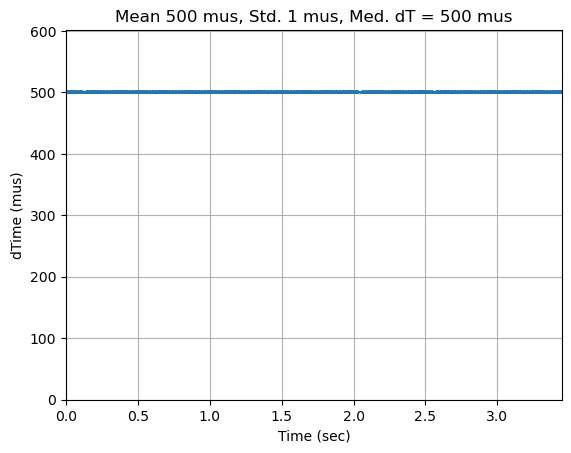

In [3]:
# Evaluate time

Ts = np.mean(np.diff(data["time"]))

plt.figure(1)
plt.plot(data["time"][:-1], np.diff(data["time"]) * 1e6)
plt.grid(True)
plt.title(f"Mean {np.mean(np.diff(data['time']) * 1e6):.0f} mus, " f"Std. {np.std(np.diff(data['time']) * 1e6):.0f} mus, " f"Med. dT = {np.median(np.diff(data['time']) * 1e6):.0f} mus")
plt.xlabel("Time (sec)")
plt.ylabel("dTime (mus)")
plt.xlim([0, data["time"][-2]])
plt.ylim([0, 1.2 * np.max(np.diff(data["time"]) * 1e6)])

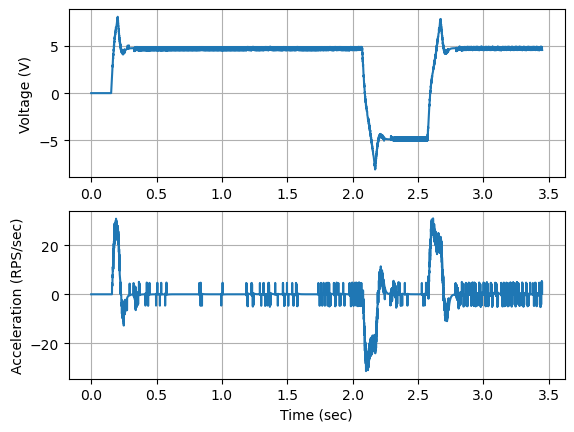

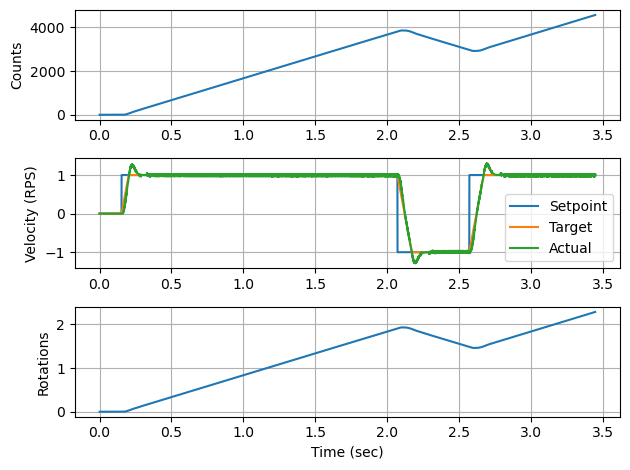

In [4]:
# Evaluate the data

# Defining the indices for the data columns
ind = {}
ind["counts"] = 0
ind["velocity"] = 1
ind["rotations"] = 2
ind["voltage"] = 3
ind["velocity_setpoint"] = 4
ind["velocity_target"] = 5

# Calculate smoothed acceleration
acceleration = np.insert(np.diff(data["values"][:, ind["velocity"]]) / Ts, 0, 0.0)  # prepend zero to match length
acceleration_smoothed = np.convolve(acceleration, np.ones(20) / 20, mode="same")

plt.figure(2)
plt.subplot(2, 1, 1)
plt.plot(data["time"], data["values"][:, ind["voltage"]])
plt.grid(True)
plt.ylabel("Voltage (V)")
plt.subplot(2, 1, 2)
plt.plot(data["time"], acceleration_smoothed)
plt.grid(True)
plt.ylabel("Acceleration (RPS/sec)")
plt.xlabel("Time (sec)")

plt.figure(3)
plt.subplot(3, 1, 1)
plt.plot(data["time"], data["values"][:, ind["counts"]])
plt.grid(True)
plt.ylabel("Counts")
plt.subplot(3, 1, 2)
plt.plot(data["time"], data["values"][:, ind["velocity_setpoint"]], label="Setpoint")
plt.plot(data["time"], data["values"][:, ind["velocity_target"]], label="Target")
plt.plot(data["time"], data["values"][:, ind["velocity"]], label="Actual")
plt.grid(True)
plt.ylabel("Velocity (RPS)")
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(data["time"], data["values"][:, ind["rotations"]])
plt.grid(True)
plt.ylabel("Rotations")
plt.xlabel("Time (sec)")
plt.tight_layout()